幅広くデータを見ていく
* 加速度の波形を並べていみる
* ウィンドウフレームごとの平均，分散の変化

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
from numpy import zeros, newaxis
import datetime
import os
import copy
import time

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"

#chopin
#StorePath = "/home/takeyama/Documents/"
#mozart
StorePath ="/media/takeyama/HD-PNFU3/01_ActivityResearchData/"
if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/')
GraphPath=StorePath+'/'+TITLE+DATE+'graph/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/corrMap/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/corrMap/')
CorrMapGraphPath=StorePath+'/'+TITLE+DATE+'graph/corrMap/'

if not os.path.exists(StorePath+'/'+TITLE+'feature/'): 
    os.makedirs(StorePath+'/'+TITLE+'feature/')
FeaturePath=StorePath+'/'+TITLE+'feature/'

センサデータの読み込み

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する

In [4]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Generate WindowFrame Function
from mymodule import window

# timer
import time

# temp file 
import tempfile

# pandas
import pandas as pd

%matplotlib inline

In [5]:
DictName = os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [6]:
Sensor5 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor1 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

In [7]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

# Methematical/Statistical Functions

## Mean, Median

In [8]:
def FastVector_Mean(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [wind[i,:].mean() for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Mean==========='
    return Output

In [9]:
def FastVector_Median(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [np.median(wind[i,:]) for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Median==========='
    return Output

## Variance, Std Deviation

In [10]:
def FastVector_Var(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [wind[i,:].var() for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Variance==========='
    return Output

In [11]:
def FastVector_StdDev(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)  
    Output = np.array( [wind[i,:].var()**0.5 for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of standard Deviation==========='
    return Output

## Min, Max, Range
Range = the difference between maximum and minimum sample values

In [12]:
def FastVector_Max(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [wind[i,:].max() for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Max==========='
    return Output

In [13]:
def FastVector_Min(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [wind[i,:].min() for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Min==========='
    return Output

In [14]:
def FastVector_Range(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [(wind[i,:].max()-wind[i,:].min())\
                        for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Range==========='
    return Output

## RMS

In [15]:
def FastVector_RMS(windowName, dataRaw, wWidth, sWidth, PATH):
    # get windowFrame
    wind=GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH)
    Output = np.array( [((np.sum( wind[i,:]**2)/wind[i,:].size)**0.5)\
                        for i in range(wind.shape[0]) ] )
    print '===========finished Making Vector of Root Means Square==========='
    return Output

## Correlation, Cross-Correlation

In [16]:
def FastVector_Corr(windowNameX, dataRawX, windowNameY, dataRawY, wWidth, sWidth, PATH):
    # get windowFrame
    windX=GetWindowFrame(windowNameX, dataRawX, wWidth, sWidth, PATH)
    windY=GetWindowFrame(windowNameY, dataRawY, wWidth, sWidth, PATH)
    Output = np.array( [( np.corrcoef(windX[i,:],windY[i,:]) )\
                    for i in range(windX.shape[0]) ] )
    print '===========finished Making Vector of Correlation==========='
    return Output[:,0,1]

# Signal magnitude area

In [17]:
def FastVector_SMA(windowName, dataRawX, dataRawY, dataRawZ, wWidth, sWidth, PATH):
    # get windowFrame
    windX=GetWindowFrame(windowName, dataRawX, wWidth, sWidth, PATH)
    windY=GetWindowFrame(windowName, dataRawY, wWidth, sWidth, PATH)
    windZ=GetWindowFrame(windowName, dataRawZ, wWidth, sWidth, PATH)
    Output = np.array( [(np.sum((windX[i,:]**2+windY[i,:]**2+windZ[i,:]**2)**0.5))\
                for i in range(windX.shape[0]) ] )
    print '===========finished Making Vector of Signal Magnitude Area==========='
    return Output  

# 各センサの相関を求める

In [18]:
labeledData=np.load(FeaturePath+'Label_Sensor1.npz')['data'][()]

In [19]:
w=window()
w.SetData('DataAddingLabel', labeledData[7,:])    
wind=w.Compile(256, 32)
windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))

DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)


In [20]:
# 重複するリストをまとめて，リストにする
def remove_duplicates(x):
    y=[]
    for i in x:
        if i not in y:
            y.append(i)
    return y

In [21]:
remove_duplicates(windoW[0])

[u'\u505c\u6b62']

In [22]:
for s in remove_duplicates(windoW[0]):
    print s

停止


In [23]:
len( np.where(windoW[0]==u'\u505c\u6b62')[0] )

256

In [24]:
def RemoveDuplicates(seq):
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if x not in seen and not seen_add(x)]

In [25]:
RemoveDuplicates(windoW[0])

[u'\u505c\u6b62']

In [26]:
[np.unique(windoW[i,:]) for i in range(windoW.shape[0]) if np.unique(windoW[i,:]).size > 1]

[array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u505c\u6b62'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u306a\u3057', u'\u6301\u3064'], dtype=object),
 array([u'\u6301\u3064', u'\u7f6e\u304f'], dtype=object),
 array([u'\u63

In [27]:
[i for i in range(windoW.shape[0]) if np.unique(windoW[i,:]).size > 1]

[516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 812,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 898,
 899,
 900,
 901,
 902,
 903,
 904,
 905,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1707,
 1708,
 1709,
 1710,
 1711,
 1712,
 1713,
 1714,
 1842,
 1843,
 1844,
 1845,
 1846,
 1847,
 1848,
 1849,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2178,
 2179,
 2180,
 2181,
 2182,
 2183,
 2184,
 2185,
 2292,
 2293,
 2294,
 2295,
 2296,
 2297,
 2298,
 2299,
 2423,
 2424,
 2425,
 2426,
 2427,
 2428,
 2429,
 2430,
 2874,
 2875,
 2876,
 2877,
 2878,
 2879,
 2880,
 2881,
 2938,
 2939,
 2940,
 2941,
 2942,
 2943,
 2944,
 2945,
 3617,
 3618,
 3619,
 3620,
 3621,
 3622,
 3623,
 3624,
 3713,
 3714,
 3715,
 3716,
 3717,
 3718,
 3719,
 3720,
 3777,
 3778,
 3779,
 3780,
 3781,
 3782,
 3783,
 3784,
 3876,
 3877,
 3878,
 3879,
 38

In [28]:
windoW[516]

array([u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62', u'\u505c\u6b62',
       u'\u505c\u6b62', u

In [29]:
np.unique(windoW[516]).size

2

In [30]:
[np.unique(windoW[516])[0]for i in range(np.unique(windoW[516]).size)]

[u'\u306a\u3057', u'\u306a\u3057']

In [31]:
# 複数のラベルがあるウィンドウ番号で，要素数が多いラベルがnp.uniqueで生成する配列のどの番号にあるか示す
np.argmax(np.array([len( np.where(windoW[516]==np.unique(windoW[516])[i])[0])for i in range(np.unique(windoW[516]).size)]))

1

In [32]:
len( np.where(windoW[516]==np.unique(windoW[516][1]))[0])

226

In [33]:
for winNum in range(7,16):
    print "***********winNum="+str(winNum)+"***********"
    w=window()
    w.SetData('DataAddingLabel', labeledData[winNum,:])    
    wind=w.Compile(256, 32)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))

    LabelArray=np.array([np.unique(windoW[l,:])[
            np.argmax(np.array([len( np.where(windoW[l]==np.unique(windoW[l])[i])[0])for i in range(np.unique(windoW[l]).size)]))]
             for l in range(windoW.shape[0])
    ])

    print LabelArray

***********winNum=7***********
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
[u'\u505c\u6b62' u'\u505c\u6b62' u'\u505c\u6b62' ..., u'\u306a\u3057'
 u'\u306a\u3057' u'\u306a\u3057']
***********winNum=8***********
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
[u'nan' u'nan' u'nan' ..., u'\u306a\u3057' u'\u306a\u3057' u'\u306a\u3057']
***********winNum=9***********
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
[u'nan' u'nan' u'nan' ..., u'\u306a\u3057' u'\u306a\u3057' u'\u306a\u3057']
***********winNum=10***********
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
[u'nan' u'nan' u'nan' ..., u'\u306a\u3057' u'\u306a\u3057' u'\u306a\u3057']
***********winNum=11***********
DataAdd

In [34]:
def MakeWindowFrameLabel(LabelData1d, wWidth, sWidth):
    w=window()
    w.SetData('DataAddingLabel', LabelData1d)    
    wind=w.Compile(wWidth, sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))

    LabelArray=np.array([np.unique(windoW[l,:])[
            np.argmax(np.array([len( np.where(windoW[l]==np.unique(windoW[l])[i])[0])for i in range(np.unique(windoW[l]).size)]))]
             for l in range(windoW.shape[0])
    ])
    return LabelArray

In [35]:
test= MakeWindowFrameLabel(labeledData[15,:], 256, 32)
print test.shape

DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
(33676,)


In [36]:
df = pd.DataFrame({
    'LeftHand-Verb':MakeWindowFrameLabel(labeledData[7,:], 256, 32),
    'LeftHand-Object':MakeWindowFrameLabel(labeledData[8,:], 256, 32),
    'RightHand-Verb':MakeWindowFrameLabel(labeledData[9,:], 256, 32),
    'RightHand-Object ':MakeWindowFrameLabel(labeledData[10,:], 256, 32),
    'Leg-Number':MakeWindowFrameLabel(labeledData[11,:], 256, 32),
    'Leg-Verb':MakeWindowFrameLabel(labeledData[12,:], 256, 32),
    'Leg-Object':MakeWindowFrameLabel(labeledData[13,:], 256, 32),
    'West':MakeWindowFrameLabel(labeledData[14,:], 256, 32),
    'ActiveNumber':MakeWindowFrameLabel(labeledData[15,:], 256, 32),
    })

DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 256, 1)
DataAddingLabel is registed now
Build Complete
Source shape is(1077870, 1)
window frames num =33676
offset=14
(33676, 

In [37]:
df

,ActiveNumber,LeftHand-Object,LeftHand-Verb,Leg-Number,Leg-Object,Leg-Verb,RightHand-Object,RightHand-Verb,West
0,NaN,nan,停止,nan,nan,nan,nan,nan,nan
1,NaN,nan,停止,nan,nan,nan,nan,nan,nan
2,NaN,nan,停止,nan,nan,nan,nan,nan,nan
3,NaN,nan,停止,nan,nan,nan,nan,nan,nan
4,NaN,nan,停止,nan,nan,nan,nan,nan,nan
5,NaN,nan,停止,nan,nan,nan,nan,nan,nan
6,NaN,nan,停止,nan,nan,nan,nan,nan,nan
7,NaN,nan,停止,nan,nan,nan,nan,nan,nan
8,NaN,nan,停止,nan,nan,nan,nan,nan,nan
9,NaN,nan,停止,nan,nan,nan,nan,nan,nan


In [47]:
drop_df = df.drop('ActiveNumber',axis=1).drop_duplicates()

In [48]:
drop_df

,LeftHand-Object,LeftHand-Verb,Leg-Number,Leg-Object,Leg-Verb,RightHand-Object,RightHand-Verb,West
0,nan,停止,nan,nan,nan,nan,nan,nan
516,なし,停止,両足,なし,歩く,なし,なし,直立
520,なし,なし,両足,なし,歩く,なし,なし,直立
600,時計,持つ,両足,なし,止まる,時計,持つ,直立
687,時計,持つ,両足,なし,歩く,時計,持つ,直立
816,時計,置く,両足,なし,止まる,時計,置く,直立
902,なし,なし,両足,なし,止まる,なし,なし,直立
1146,雑誌,持つ,両足,なし,止まる,雑誌,持つ,直立
1359,雑誌,持つ,両足,なし,歩く,雑誌,持つ,直立
1497,雑誌,持つ,両足,なし,止まる,雑誌,持つ,前かがみ


In [38]:
for c in df.columns:
    print 'columns='+c+' unique='+str( len( df[c].unique() ) )

columns=ActiveNumber unique=16
columns=LeftHand-Object unique=24
columns=LeftHand-Verb unique=13
columns=Leg-Number unique=2
columns=Leg-Object unique=2
columns=Leg-Verb unique=5
columns=RightHand-Object  unique=23
columns=RightHand-Verb unique=14
columns=West unique=3


In [39]:
for key in df['ActiveNumber'].unique():
    print 'Columns='+str(key)+' count='+str(df[df['ActiveNumber']==key].shape[0] )

Columns=nan count=0
Columns=0.0 count=84
Columns=101.0 count=454
Columns=102.0 count=1535
Columns=103.0 count=1380
Columns=104.0 count=285
Columns=105.0 count=1149
Columns=106.0 count=147
Columns=107.0 count=284
Columns=108.0 count=7411
Columns=109.0 count=264
Columns=110.0 count=7200
Columns=111.0 count=2274
Columns=112.0 count=1681
Columns=113.0 count=4163
Columns=114.0 count=4849


In [40]:
ActinName=np.array(['行動開始',
'時計の運搬',
'雑誌の整理',
'雑誌，本棚の掃除',
'雑誌，本棚の掃除で用いた道具の片付け',
'雑巾がけ',
'雑巾の片付け',
'時計の片付け',
'ホウキを用いた掃除',
'ホウキの片付け',
'掃除機を用いた掃除',
'掃除位の片付け',
'モップシートの交換',
'モップを用いた掃除',
'モップの片付け'])


In [41]:
"""
ウィンドウ幅 256
スライド幅 32
上記の設定でウィドウフレームを生成した

そして，各行動別にどのくらいのラベルがあるのかを調べた結果が以下の
通りである．
"""
for AN,key in zip(ActinName, df['ActiveNumber'].unique() ):
    print 'ActionName='+AN+'__'+str(df[df['ActiveNumber']==key].shape[0] )
    
KindOfLabel = np.array([df[df['ActiveNumber']==key].shape[0] for key in df['ActiveNumber'].unique()])

ActionName=行動開始__0
ActionName=時計の運搬__84
ActionName=雑誌の整理__454
ActionName=雑誌，本棚の掃除__1535
ActionName=雑誌，本棚の掃除で用いた道具の片付け__1380
ActionName=雑巾がけ__285
ActionName=雑巾の片付け__1149
ActionName=時計の片付け__147
ActionName=ホウキを用いた掃除__284
ActionName=ホウキの片付け__7411
ActionName=掃除機を用いた掃除__264
ActionName=掃除位の片付け__7200
ActionName=モップシートの交換__2274
ActionName=モップを用いた掃除__1681
ActionName=モップの片付け__4163


In [42]:
KindOfLabel

array([   0,   84,  454, 1535, 1380,  285, 1149,  147,  284, 7411,  264,
       7200, 2274, 1681, 4163, 4849])

<Container object of 15 artists>

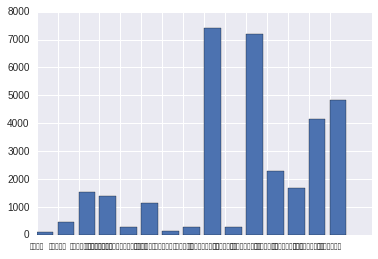

In [43]:
plt.bar(xrange(KindOfLabel[1:].shape[0]), KindOfLabel[1:], tick_label=ActinName)